### General Concept

Given a png/jpg file of a STNK, get values of table. The png/jpg has various tilt angles and can be messy with multiple folds, marks and dirt in the paper that can occlude info

1. Use homography to find a stabilized format orientation from the tilted image
2. Use thresholding and OCR model to read specific contours from the edited image
3. Sort OCR outputs into text.

### Import Dump

In [85]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import warnings


warnings.simplefilter(action='ignore', category=FutureWarning)

### Homography

Since the scans of the STNKs can be tilted, it is best to first tilt it to a clean original non-tilted format like the pdfs. This is so the structure of the image retains stability and structure with any tilted image. Homography is used for this.

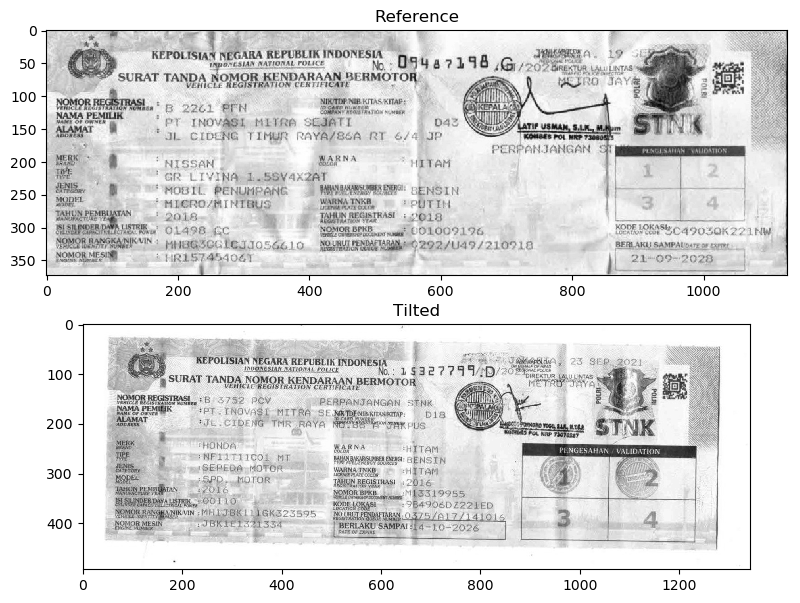

In [86]:
filename = "stnk2_2.jpg"

# read reference stable image
ref = cv2.imread("clean_stnk2.png")
ex = cv2.imread(filename)

# convert to grayscale
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
ex = cv2.cvtColor(ex, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,7))

plt.subplot(211); plt.title("Reference"); plt.imshow(ref, cmap="gray")
plt.subplot(212); plt.title("Tilted"); plt.imshow(ex, cmap="gray")

Create ORBs (Orientated fast Rotated Brief) to highlight keypoints from both images

Text(0.5,1,'Example')

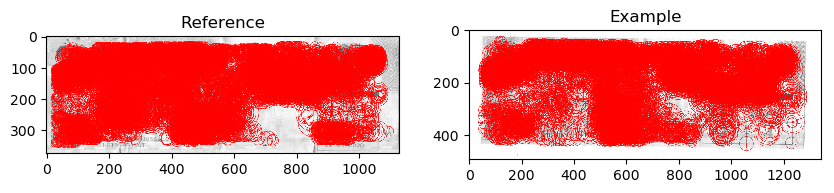

In [87]:
# create orbs (keypoints)
orb = cv2.ORB_create(10000)
ref_keypoints, ref_descs = orb.detectAndCompute(ref, None)
ex_keypoints, ex_descs = orb.detectAndCompute(ex, None)

# display orbs
ref_orbs = cv2.drawKeypoints(ref, ref_keypoints, outImage=np.array([]), color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
ex_orbs = cv2.drawKeypoints(ex, ex_keypoints, outImage=np.array([]), color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10,7))

plt.subplot(121); plt.imshow(ref_orbs); plt.title("Reference")
plt.subplot(122); plt.imshow(ex_orbs); plt.title("Example")

Find geometric relationship and mapping from both images

(-0.5, 2470.5, 492.5, -0.5)

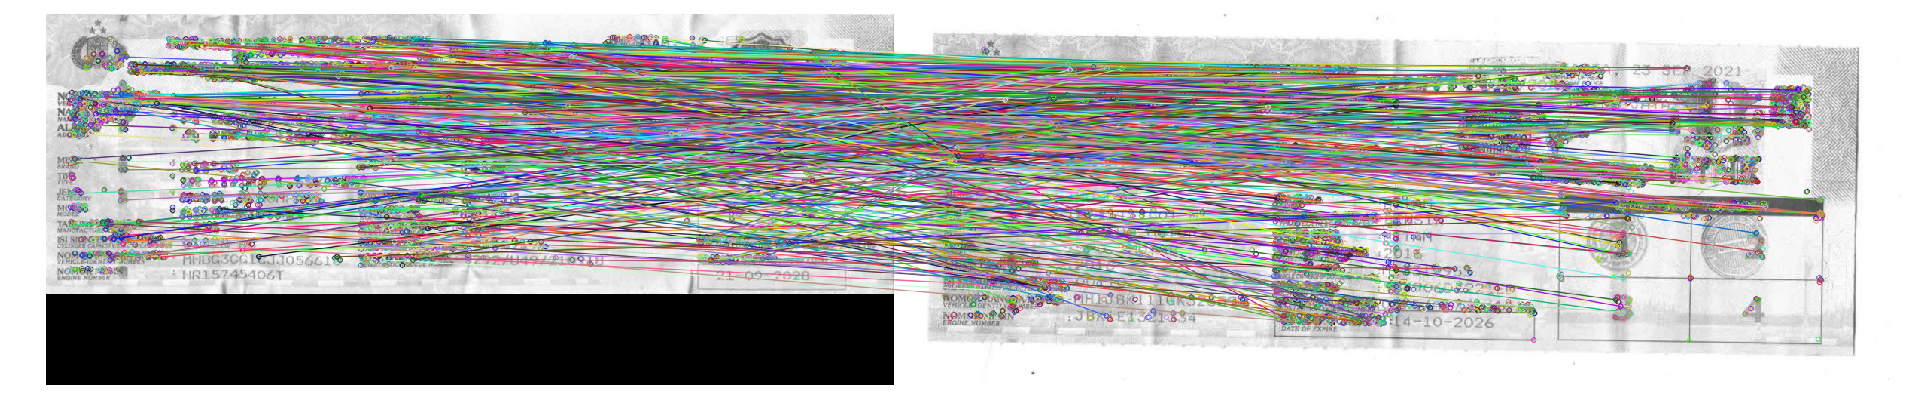

In [88]:
# create matcher
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE)

# connect descriptors
matches = list(matcher.match(ref_descs, ex_descs, None))

# sort matches by score
matches.sort(key=lambda x: x.distance)

# remove bad score matches
num_of_good_matches = int(len(matches) * 0.07)
matches = matches[:num_of_good_matches]

# display matches
matches_img = cv2.drawMatches(ref, ref_keypoints, ex, ex_keypoints, matches, None)

plt.figure(figsize=(24,8))
plt.imshow(matches_img)
plt.axis("off")

With good mappings, create homography

In [89]:
# get locations of good matches
ref_points = np.zeros((len(matches), 2), dtype=np.float32)
ex_points = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    ref_points[i, :] = ref_keypoints[match.queryIdx].pt
    ex_points[i, :] = ex_keypoints[match.trainIdx].pt

# find homography
homo, mask = cv2.findHomography(ex_points, ref_points, cv2.RANSAC)

homo

array([[ 9.38398174e-01,  2.73513351e-02, -5.37419876e+01],
       [-1.71050608e-02,  9.43501394e-01, -2.53346728e+01],
       [ 1.79522408e-06,  8.25668432e-05,  1.00000000e+00]])

Warp perspective of image as defined by homography

Text(0.5,1,'Warped Example')

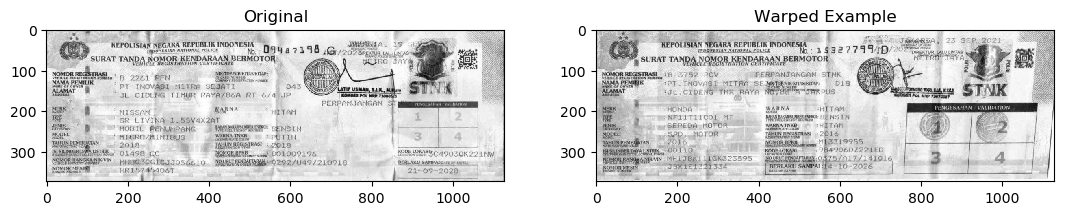

In [90]:
# warp image with homography
height, width = ref.shape
ex_warped = cv2.warpPerspective(ex, homo, (width, height))

# display result
plt.figure(figsize=[13, 10])

plt.subplot(121); plt.imshow(ref, cmap="gray"); plt.title("Original")
plt.subplot(122); plt.imshow(ex_warped, cmap="gray"); plt.title("Warped Example")

### Scanning

In [91]:
# define OCR model
checkpoint = "microsoft/trocr-base-printed" 
processor = TrOCRProcessor.from_pretrained(checkpoint)
model = VisionEncoderDecoderModel.from_pretrained(checkpoint)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Display image to be processed at full

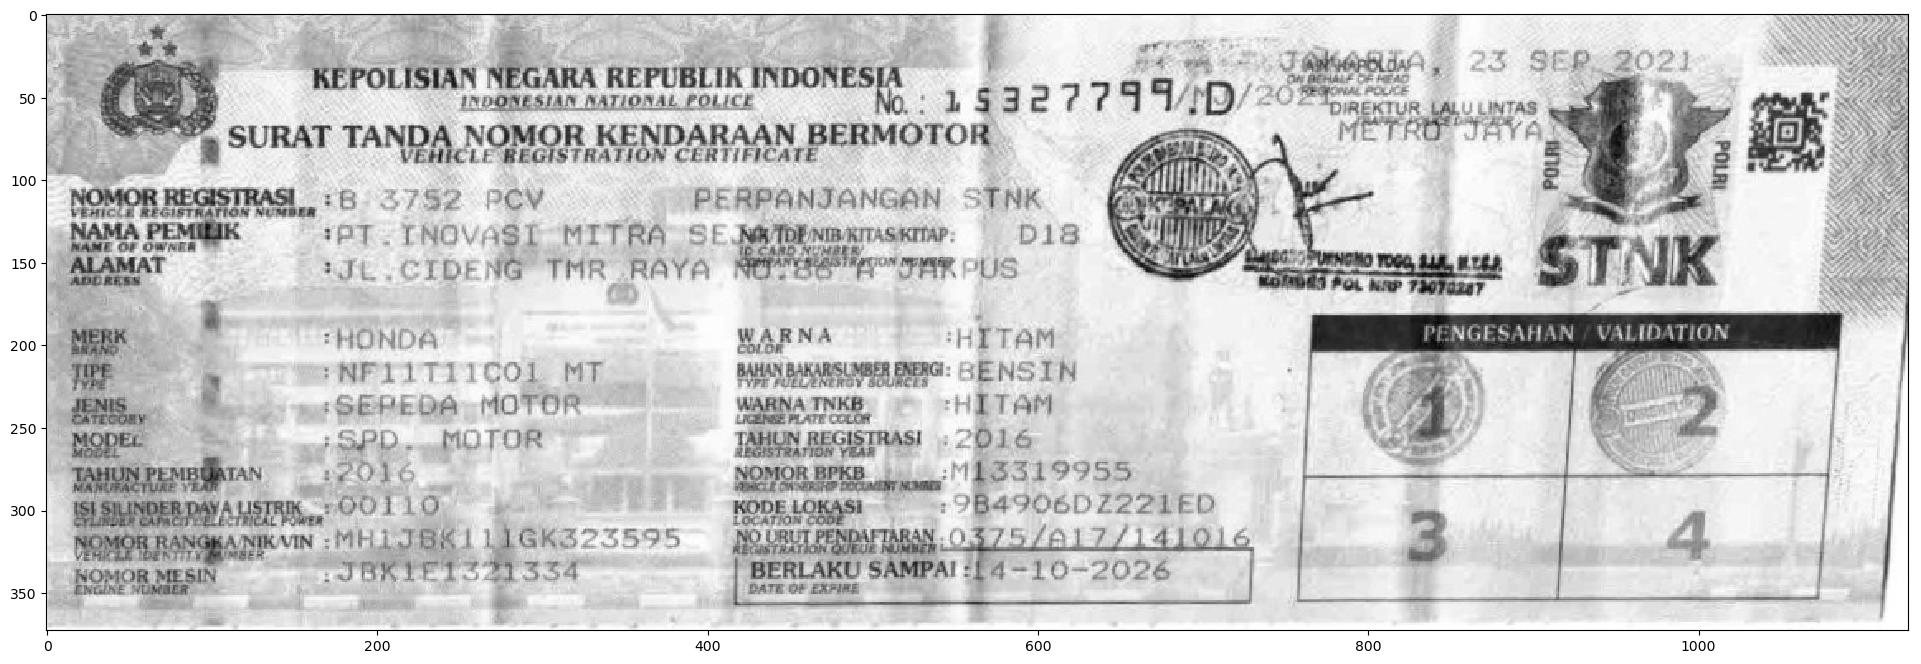

In [92]:
plt.figure(figsize=(30,8))
plt.imshow(ex_warped, cmap="gray")

Create a threshold for creating pure monochrome image

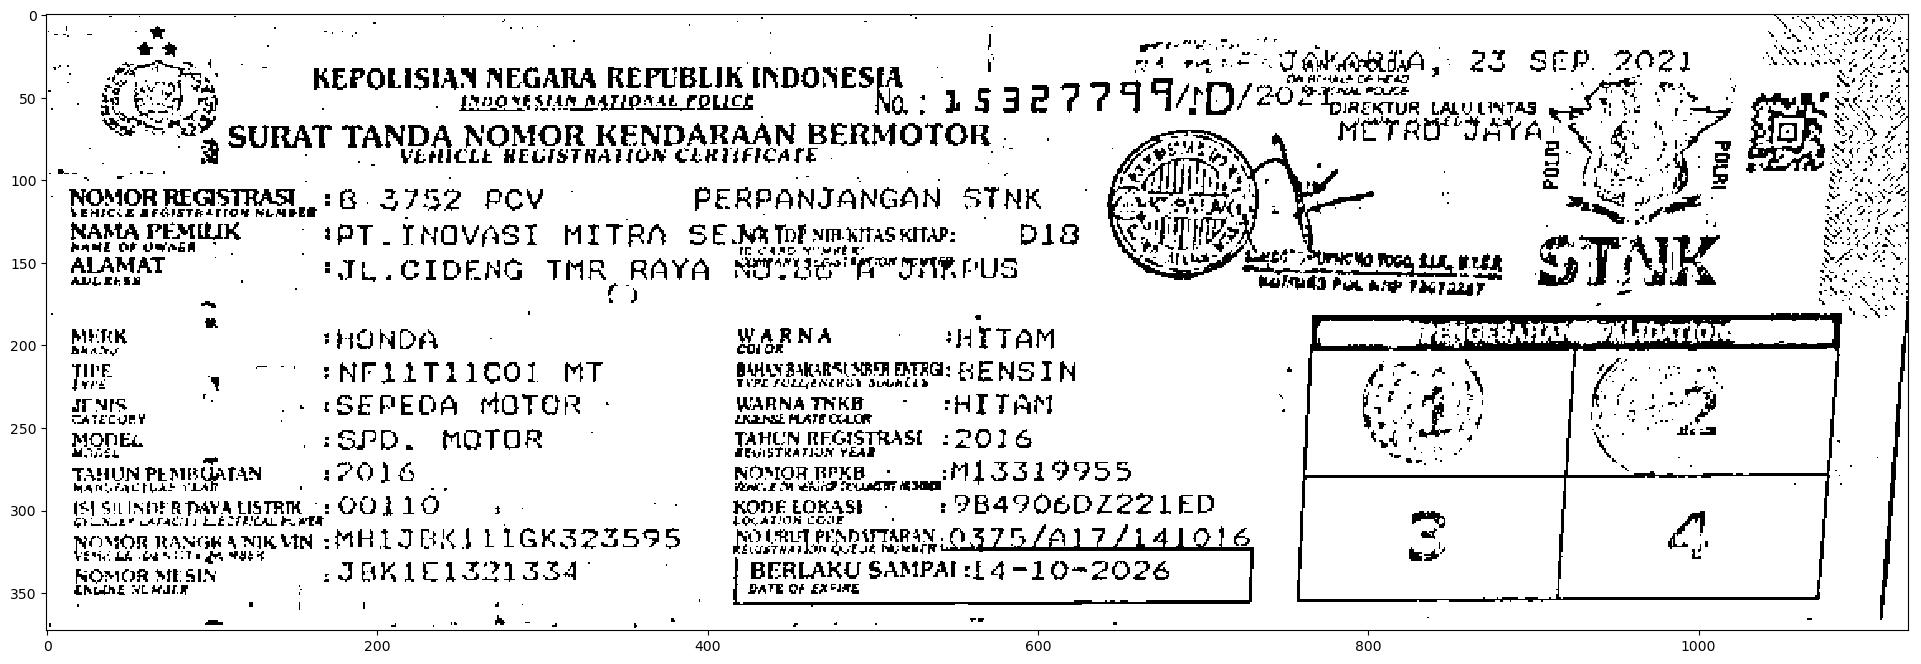

In [93]:
# make threshold image (maybe more optimal values exists)
thresh = cv2.adaptiveThreshold(ex_warped, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 20)

# show monochrome image
plt.figure(figsize=(30,8))
plt.imshow(thresh, cmap="gray")

The ROI (region of interest) is the table at the bottom left. Therefore crop into two images of only the values of the table. The format and orientation of the image will always be like the reference image therefore using constant pixels to determine the contours for the ROI in this case is fine.

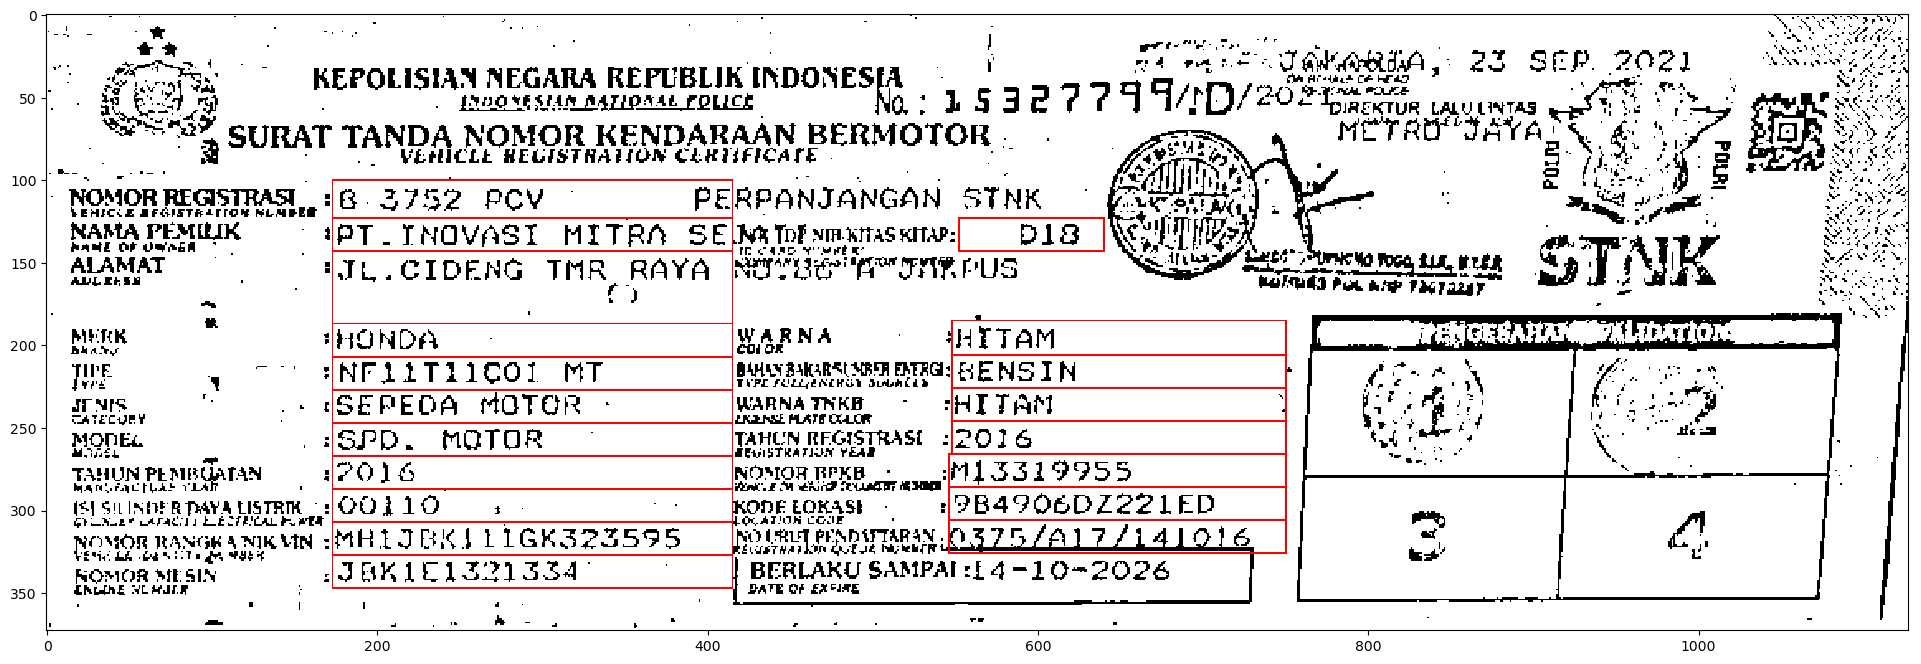

In [94]:
contour_boxes = thresh.copy()
contour_boxes = cv2.cvtColor(contour_boxes, cv2.COLOR_GRAY2BGR)

# coords for roi (x1, x2, y1, y2)
coords = [
    (173, 415, 100, 123),
    (173, 415, 123, 143),
    (173, 415, 143, 187),
    (173, 415, 187, 207),
    (173, 415, 207, 227),
    (173, 415, 227, 247),
    (173, 415, 247, 267),
    (173, 415, 267, 287),
    (173, 415, 287, 307),
    (173, 415, 307, 327),
    (173, 415, 327, 347),
    (552, 640, 123, 143),
    (548, 750, 185, 206),
    (548, 750, 206, 226),
    (548, 750, 226, 246),
    (548, 750, 246, 266),
    (546, 750, 266, 286),
    (546, 750, 286, 306),
    (546, 750, 306, 326)
]

# Draw contours for ROI
for c in coords:
    cv2.rectangle(contour_boxes, (c[0], c[2]), (c[1], c[3]), (255, 0, 0), 1)

plt.figure(figsize=(30,8))
plt.imshow(contour_boxes)

In [95]:
croppings = thresh.copy()
croppings = cv2.cvtColor(croppings, cv2.COLOR_GRAY2BGR)
texts = []

# inference
for c in coords:
    px = processor(croppings[c[2]:c[3],c[0]:c[1]], return_tensors="pt").pixel_values
    gen_ids = model.generate(px)
    gen_text = processor.batch_decode(gen_ids, skip_special_tokens=True)[0]
    texts.append(gen_text)
    print(gen_text)

c:\Users\paoma\miniconda3\lib\site-packages\transformers\generation\utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


B-3752 PCV : PEE
PT.INOVASI MITRA SE
JL.CIDENG TMR,RAYA
HONDA
NF11T11C01 MT
SEPEDA MOTOR.
SPD. MOTOR
2016
00110 :
MHIJBKJLIGK323595
JBK1E1321334
D18
HITAM
BENSIN
HITAM (RM)
2016
M13319955
984906DZ22LED
0375/A17/141016


In [96]:
name_col = [
    "Nomor Registrasi",
    "Nama Pemilik",
    "Alamat",
    "Merk",
    "Tipe",
    "Jenis",
    "Model",
    "Tahun Pembuatan",
    "Daya Listrik",
    "Nomor Rangka",
    "Nomor Mesin",
    "ID",
    "Warna",
    "Sumber Energi",
    "Warna TNKB",
    "Tahun Registrasi",
    "Nomor BPKB",
    "Kode Lokasi",
    "Nomor Urut Pendaftaran"
]

# put to dataframe
df = pd.DataFrame({
    "Name": name_col,
    "Info": texts
})

In [97]:
# export dataframe to csv file
csv_name = filename[:-4] + "_info.csv"
df.to_csv(csv_name, index=False)